<h1 style="text-align: center; color: #E30613;"><b><i>Entraînement avec LSTM sur les Données de Sentiments</i></b></h1>

<p style="font-size: 18px; color: #333;">
Ce notebook présente une approche complète pour l'entraînement d'un modèle LSTM (Long Short-Term Memory) sur des données de sentiments. 
L'objectif est de prédire les sentiments exprimés dans des commentaires textuels en utilisant des techniques avancées de traitement du langage naturel (NLP).
</p>

### <span style="color: #28A745;">**Étapes principales du workflow :**</span>

1. **Chargement des données :** Importation et nettoyage des données textuelles.
2. **Encodage des étiquettes :** Transformation des sentiments en valeurs numériques.
3. **Division des données :** Séparation des données en ensembles d'entraînement, de validation et de test.
4. **Vectorisation :** Conversion des textes en vecteurs numériques à l'aide de `CountVectorizer`.
5. **Création d'un Dataset personnalisé :** Préparation des données pour le DataLoader de PyTorch.
6. **Définition du modèle LSTM :** Construction et configuration du modèle LSTM pour la classification.
7. **Entraînement :** Optimisation des paramètres du modèle à l'aide de la descente de gradient.
8. **Évaluation :** Analyse des performances du modèle avec des métriques et des visualisations.

### <span style="color: #28A745;">**Technologies utilisées :**</span>

- **PyTorch :** Framework pour la construction et l'entraînement du modèle LSTM.
- **Scikit-learn :** Prétraitement des données et évaluation des performances.
- **Matplotlib & Seaborn :** Visualisation des résultats et des métriques.
- **TQDM :** Suivi des progrès pendant l'entraînement.

<p style="font-size: 16px; color: #555;">
<b>Note :</b> Ce projet est conçu pour démontrer une approche pratique et reproductible pour l'analyse des sentiments à l'aide de réseaux de neurones récurrents.
</p>

# <span style="color: #E30613;">**LSTM**</span>

## <span style="color: #28A745;">**Bibiliothèques nécessaires**</span>

In [10]:
%pip install torch torchvision torchaudio scikit-learn matplotlib tqdm pandas

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

## <span style="color: #28A745;">**Utilisation de GPU**</span>

In [17]:
# ✅ GPU seulement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## <span style="color: #28A745;">**Chargement des Données**</span>

In [18]:
# 📁 Chargement des données
df = pd.read_csv("/content/Results/Comments_clean.csv")
df = df.dropna(subset=["Comments"])

## <span style="color: #28A745;">**Encodage des étiquettes**</span>

In [19]:
# 🎯 Encodage des étiquettes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])

## <span style="color: #28A745;">**Division des données**</span>

In [20]:
# ✂️ Division des données
X_temp, X_test, y_temp, y_test = train_test_split(df["Comments"], df["Sentiments_encoded"], test_size=0.2, random_state=42, stratify=df["Sentiments_encoded"])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)  # 0.125 * 0.8 = 0.1

## <span style="color: #28A745;">**Vectorisation avec CountVectorizer**</span>

In [21]:
# 🧠 Vectorisation avec CountVectorizer
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

## <span style="color: #28A745;">**Dataset personnalisé**</span>

In [22]:
# 📦 Dataset personnalisé
class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CommentDataset(X_train_vec, y_train)
val_dataset = CommentDataset(X_val_vec, y_val)
test_dataset = CommentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## <span style="color: #28A745;">**Entraînement avec LSTM**</span>

In [24]:
# 🧱 Modèle LSTM
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return self.softmax(out)

input_dim = X_train_vec.shape[1]
model = SentimentLSTM(input_dim=input_dim, hidden_dim=128, output_dim=3, n_layers=2, dropout=0.4)
model = model.to(device)

# 🔧 Entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-6, eps=0.00001)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_loss = float('inf')
patience = 2  # Nombre d'époques sans amélioration avant l'arrêt anticipé
epochs_no_improve = 0

for epoch in range(100):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/content/Results/best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("⛔ Early stopping triggered")
            break

Epoch 1 [Training]: 100%|██████████| 80/80 [00:00<00:00, 144.89it/s, loss=0.569]



Epoch 1 - Train Loss: 1.0714, Val Loss: 1.0019, Train Acc: 0.4144, Val Acc: 0.4586


Epoch 2 [Training]: 100%|██████████| 80/80 [00:00<00:00, 140.92it/s, loss=1.32]



Epoch 2 - Train Loss: 0.8908, Val Loss: 0.8547, Train Acc: 0.6501, Val Acc: 0.6823


Epoch 3 [Training]: 100%|██████████| 80/80 [00:00<00:00, 136.55it/s, loss=0.6]



Epoch 3 - Train Loss: 0.7469, Val Loss: 0.7712, Train Acc: 0.8501, Val Acc: 0.8039


Epoch 4 [Training]: 100%|██████████| 80/80 [00:00<00:00, 99.62it/s, loss=0.552]



Epoch 4 - Train Loss: 0.6566, Val Loss: 0.7382, Train Acc: 0.9095, Val Acc: 0.8204


Epoch 5 [Training]: 100%|██████████| 80/80 [00:00<00:00, 93.14it/s, loss=0.553]



Epoch 5 - Train Loss: 0.6260, Val Loss: 0.7264, Train Acc: 0.9348, Val Acc: 0.8287


Epoch 6 [Training]: 100%|██████████| 80/80 [00:01<00:00, 63.63it/s, loss=1.2]



Epoch 6 - Train Loss: 0.6116, Val Loss: 0.7179, Train Acc: 0.9462, Val Acc: 0.8343


Epoch 7 [Training]: 100%|██████████| 80/80 [00:01<00:00, 59.69it/s, loss=0.557]



Epoch 7 - Train Loss: 0.6048, Val Loss: 0.7134, Train Acc: 0.9494, Val Acc: 0.8343


Epoch 8 [Training]: 100%|██████████| 80/80 [00:01<00:00, 72.05it/s, loss=0.553]



Epoch 8 - Train Loss: 0.5989, Val Loss: 0.7153, Train Acc: 0.9553, Val Acc: 0.8232


Epoch 9 [Training]: 100%|██████████| 80/80 [00:00<00:00, 94.07it/s, loss=0.551]



Epoch 9 - Train Loss: 0.5934, Val Loss: 0.7125, Train Acc: 0.9605, Val Acc: 0.8287


Epoch 10 [Training]: 100%|██████████| 80/80 [00:01<00:00, 63.29it/s, loss=0.551]



Epoch 10 - Train Loss: 0.5912, Val Loss: 0.7165, Train Acc: 0.9632, Val Acc: 0.8232


Epoch 11 [Training]: 100%|██████████| 80/80 [00:00<00:00, 114.69it/s, loss=0.551]



Epoch 11 - Train Loss: 0.5880, Val Loss: 0.7187, Train Acc: 0.9660, Val Acc: 0.8260
⛔ Early stopping triggered


## <span style="color: #28A745;">**Graphique des pertes**</span>

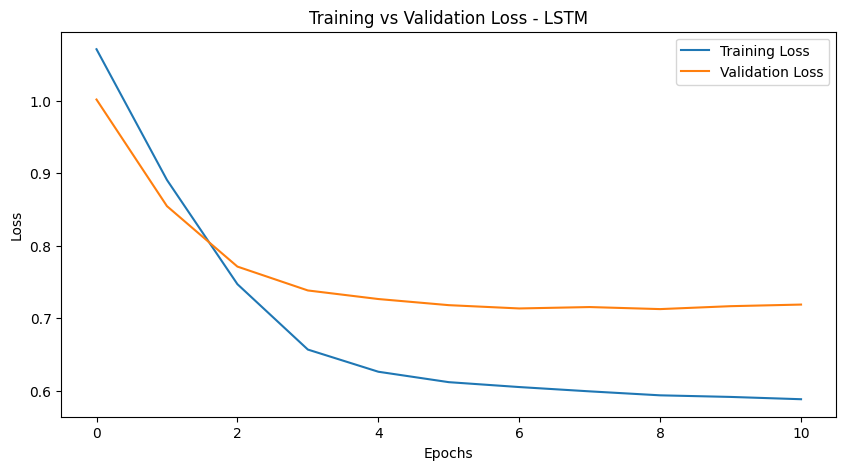

In [25]:
# 📉 Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - LSTM")
plt.legend()
plt.show()

## <span style="color: #28A745;">**Évaluation finale**</span>

In [ ]:
# ✅ Évaluation finale
model.load_state_dict(torch.load("/content/Results/best_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 📊 Rapport de classification
print("\n🔍 Rapport de classification pour LSTM:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Rapport de classification pour LSTM:
              precision    recall  f1-score   support

     Negatif       0.91      0.83      0.87       172
      Neutre       0.79      0.84      0.81       236
     Positif       0.92      0.91      0.92       315

    accuracy                           0.87       723
   macro avg       0.87      0.86      0.87       723
weighted avg       0.87      0.87      0.87       723



## <span style="color: #28A745;">**Matrice de confusion**</span>

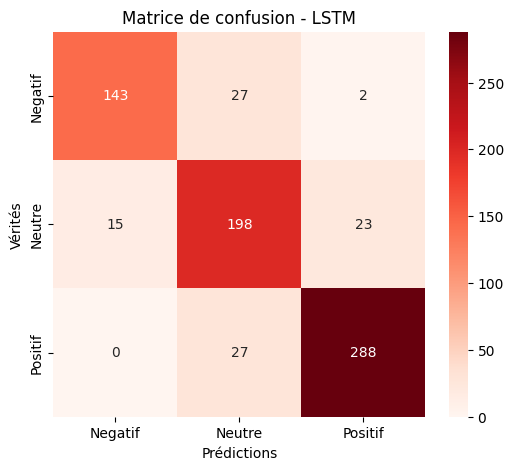

In [27]:
# 📌 Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - LSTM")
plt.show()

<h3 style="text-align: center; color: #E30613;"><b><i>Développé par: OUARAS Khelil Rafik</i></b></h3>